Library


In [156]:
import math
import joblib
import numpy as np
from scipy import signal, fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly
import os
import pandas as pd
import json
import pickle
from typing import Tuple, List

Konstanta


In [157]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"

Dir Folder


In [158]:
dir_data_xc = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto"
dir_data_nad = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data"

# Pra-Pemrosesan


In [159]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    """Load audio file using librosa (automatically resamples to target SR if needed)"""
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    """Convert to mono by averaging channels if multichannel"""
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    """Resample audio to target sample rate using librosa (higher quality)"""
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    """Pad audio to make length a multiple of SEGMENT_DURATION"""
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    """Split audio into overlapping segments using numpy"""
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

In [160]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

In [161]:
audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto\19655.mp3"
audio = prapemrosesan(audio_path)
print(audio)

[[-6.6490856e-13 -2.0503420e-13  1.9726230e-12 ...  1.7010156e-02
   1.5655354e-02  1.3218733e-02]
 [ 6.9998251e-03 -2.3220887e-03 -9.3276333e-03 ... -4.0571913e-02
  -6.0787849e-02 -5.0007358e-02]
 [ 7.4740639e-03 -2.3474745e-03 -1.5351549e-02 ...  1.9005135e-02
   5.9014216e-02  4.4121876e-02]
 ...
 [-7.4782409e-02 -9.3011327e-02 -2.4965525e-02 ...  1.6005744e-03
  -3.3666354e-03 -8.3865821e-03]
 [-1.1490545e-02 -2.3795087e-02 -9.9513810e-03 ... -5.9259287e-03
  -1.1444697e-02 -8.6035309e-03]
 [-9.7558107e-03 -5.4592136e-03  2.4177516e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


# Ekstraksi Fitur


In [162]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_zcr(segment):
    return np.mean(librosa.feature.zero_crossing_rate(y=segment))

def get_lms(segment):
    return librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)

# Ekstraksi Data


In [163]:
list_segments_xc = [
    ("19655.mp3", [[1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [5.0, 6.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5]]),
    ("90809.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5]]),
    ("151761.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
    ("193835.mp3", [[1.5, 2.5], [3.0, 4.0], [4.5, 5.5], [7.5, 8.5], [9.5, 10.5], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [18.0, 19.0], [19.5, 20.5], [21.0, 22.0]]),
    ("279210.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0]]),
    ("282469.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [4.5, 5.5], [8.0, 9.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]),
    ("359523.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [5.0, 6.0], [5.5, 6.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [15.0, 16.0], [16.5, 17.5]]),
    ("359552.mp3", [[0.5, 1.5], [1.0, 2.0], [4.0, 5.0], [4.5, 5.5], [6.0, 7.0], [6.5, 7.5], [8.5, 9.5], [12.0, 13.0], [14.0, 15.0]]),
    ("498380.mp3", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5]]),
    ("505545.mp3", [[2.5, 3.5], [4.0, 5.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [22.0, 23.0], [22.5, 23.5]]),
    ("531042.mp3", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0]]),
]

list_segments_nad = [
    ("1-100032-A-0.wav", [[2.0, 3.0]]),
    ("1-100038-A-14.wav", [[0.0, 1.0]]),
    ("1-100210-A-36.wav", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-100210-B-36.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5]]),
    ("1-101296-A-19.wav", []),
    ("1-101296-B-19.wav", []),
    ("1-101336-A-30.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]),
    ("1-101404-A-34.wav", [[0.0, 1.0]]),
    ("1-103298-A-9.wav", [[0.0, 1.0], [1.5, 2.5], [4.0, 5.0]]),
    ("1-103995-A-30.wav", [[0.0, 1.0]]),
    ("1-103999-A-30.wav", [[0.0, 1.0]]),
    ("1-104089-A-22.wav", [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-104089-B-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-105224-A-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-110389-A-0.wav", [[0.0, 1.0]]),
    ("1-110537-A-22.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-115521-A-19.wav", [[0.0, 1.0], [3.5, 4.5]]),
    ("1-115545-A-48.wav", []),
    ("1-115545-B-48.wav", [[0.0, 1.0]]),
    ("1-115545-C-48.wav", [[0.5, 1.5]]),
    ("1-115546-A-48.wav", [[0.5, 1.5]]),
    ("1-115920-B-22.wav", []),
    ("1-115921-A-22.wav", []),
    ("1-116765-A-41.wav", [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-11687-A-47.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5]]),
    ("1-118206-A-31.wav", []),
    ("1-118559-A-17.wav", []),
    ("1-121951-A-8.wav", []),
    ("1-13571-A-46.wav", [[0.0, 1.0], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-13572-A-46.wav", [[2.0, 3.0]]),
    ("1-13613-A-37.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-137-A-32.wav", []),
    ("1-977-A-39.wav", [[0.0, 1.0]]),
    ("1-1791-A-26.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0]]),
    ("1-7974-A-49.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [3.5, 4.5], [4.0, 5.0]]),
    ("1-7974-B-49.wav", [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0]]),
]

# Visualize


In [164]:
def load_and_plot(path, list_result, final_time):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

    plt.xticks(np.arange(0, final_time, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, final_time)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [165]:
# for data in list_segments_nad:
#     load_and_plot(os.path.join(dir_data_nad, data[0]), data[1], 5.1)

In [166]:
# for data in list_segments_xc:
#     load_and_plot(os.path.join(dir_data_xc, data[0]), data[1], 25.1)

# Labeling Timestamp


Helper


In [167]:
def generate_timestamps(duration):
    list_timestamp = []

    for i in np.arange(0, duration-0.5, 0.5):
        list_timestamp.append([i, i+1.0])

    return list_timestamp

def labeling_list(audio_path, list_label, label_dataset):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    list_timestamp = generate_timestamps(len(audio) / SAMPLE_RATE)

    list_timestamp_label = []
    for timestamp in list_timestamp:
        if timestamp in list_label:
            list_timestamp_label.append((audio_path, timestamp, label_dataset))
        else:
            list_timestamp_label.append((audio_path, timestamp, 2))

    return list_timestamp_label

Generate List Labelled Timestamp


In [168]:
list_timestamp_label_xc = []
for file in list_segments_xc:
    list_timestamp_label_xc += labeling_list(os.path.join(dir_data_xc, file[0]), file[1], 0)

list_timestamp_label_nad = []
for file in list_segments_nad:
    list_timestamp_label_nad += labeling_list(os.path.join(dir_data_nad, file[0]), file[1], 1)

In [169]:
dataset_labelled = list_timestamp_label_xc + list_timestamp_label_nad

In [170]:
dataset_labelled

[('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [0.0, 1.0],
  2),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [0.5, 1.5],
  2),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [1.0, 2.0],
  2),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [1.5, 2.5],
  0),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [2.0, 3.0],
  0),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [2.5, 3.5],
  0),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  [3.0, 4.0],
  0),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artif

# Extract Features


In [232]:
dataset_fe = []

for data in dataset_labelled:
    segments = prapemrosesan(data[0])
    index = int(data[1][0] / 0.5)
    segment = segments[index]
    rms = get_rms(segment)
    zcr = get_zcr(segment)
    lms = get_lms(segment)
    dataset_fe += [(data[0], data[1][0], data[1][1] - data[1][0], data[2], rms, zcr, lms)]

In [233]:
dataset_fe

[('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  0.0,
  1.0,
  2,
  0.011059444,
  0.23255173703457446,
  array([[2.22129905e-13, 1.03116427e-09, 1.56951060e-07, ...,
          5.70585842e-13, 1.14141976e-07, 3.86931497e-05],
         [1.73044982e-13, 1.74463599e-09, 6.80466954e-08, ...,
          5.17760639e-13, 1.17636276e-07, 3.98712073e-05],
         [1.94202402e-13, 1.31313471e-09, 1.05966667e-08, ...,
          2.38242260e-12, 1.35159581e-07, 4.56374873e-05],
         ...,
         [2.20867216e-16, 3.81760608e-16, 5.07324878e-16, ...,
          5.14235058e-14, 2.11715911e-09, 6.91677428e-07],
         [9.88679711e-21, 1.61993748e-18, 5.16642328e-18, ...,
          3.58666228e-16, 2.08386641e-09, 6.80778953e-07],
         [4.95487801e-22, 1.56139436e-20, 6.90402098e-21, ...,
          3.08383758e-16, 2.06350248e-09, 6.74107753e-07]], dtype=float32)),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artifici

In [235]:
dataset_rmszcr = []

for data in dataset_fe:
    dataset_rmszcr += [(data[0], data[1], data[2], data[3], data[4], data[5])]

In [236]:
df = pd.DataFrame(dataset_rmszcr, columns=["file", "start", "end", "label", "rms", "zcr"])

# Visualize Labels


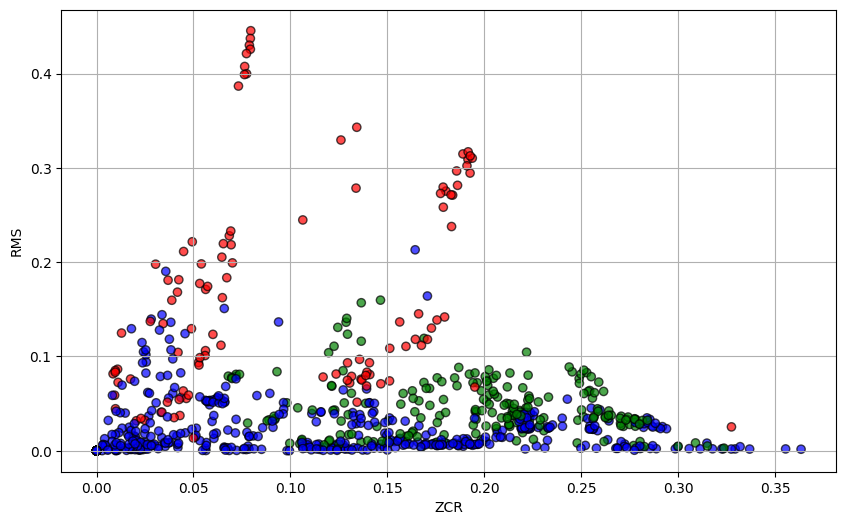

In [237]:
colors = df['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df['zcr'], df['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.grid(True)
plt.show()

In [238]:
df_0 = df[df["label"] == 0]
df_1 = df[df["label"] == 1]
df_2 = df[df["label"] == 2]

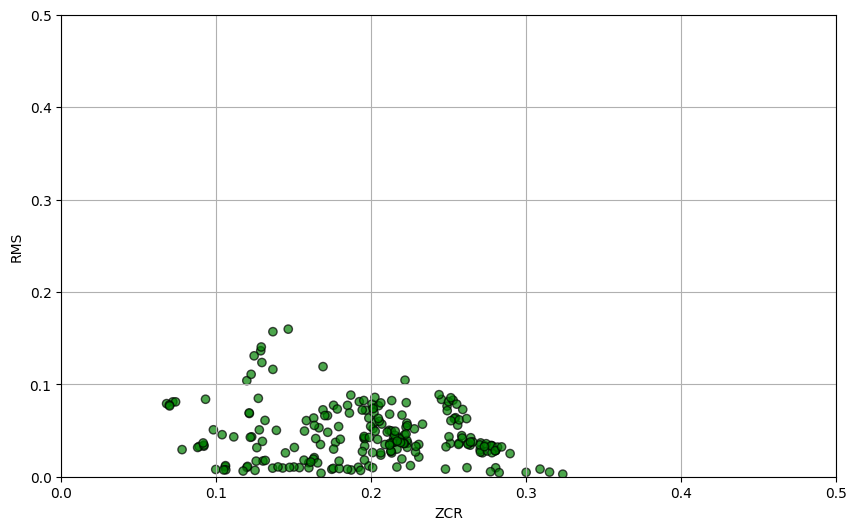

In [239]:
colors = df_0['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_0['zcr'], df_0['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

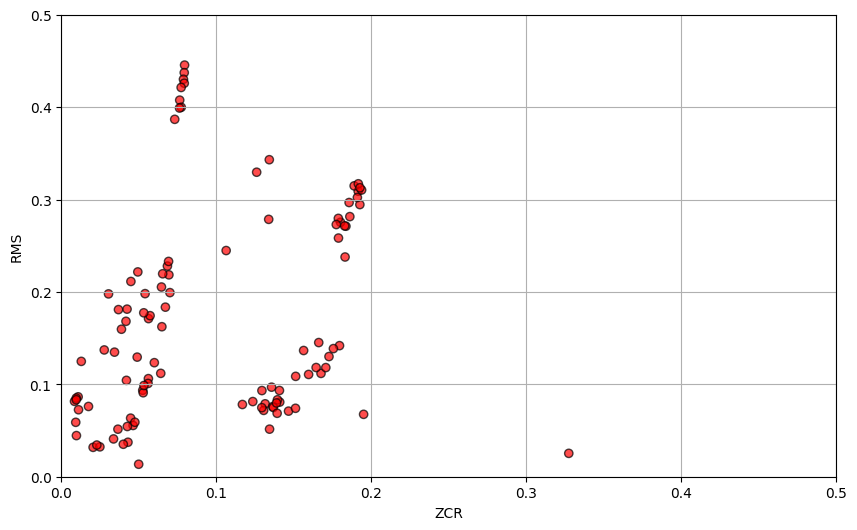

In [240]:
colors = df_1['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_1['zcr'], df_1['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

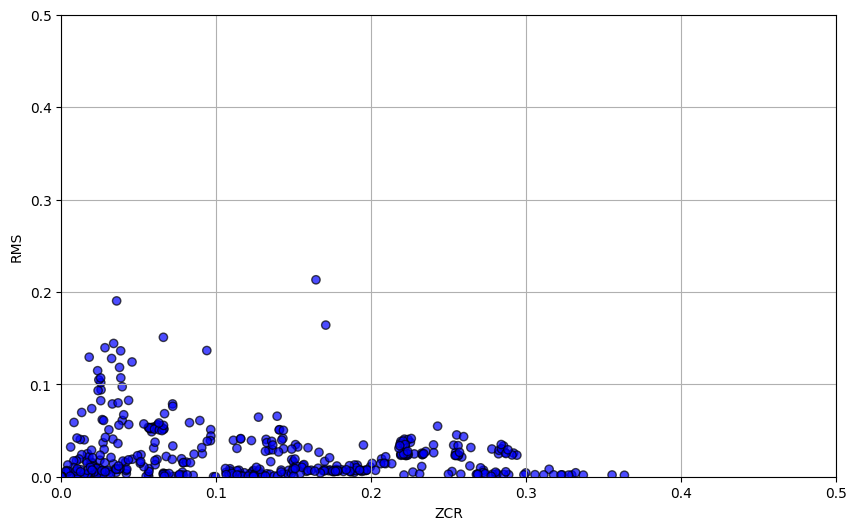

In [241]:
colors = df_2['label'].map({2: 'blue', 1: 'red', 0:'green'})
plt.figure(figsize=(10, 6))
plt.scatter(df_2['zcr'], df_2['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('RMS')
plt.xlabel('ZCR')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

# LR


In [242]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [243]:
X = [(data[4], data[5]) for data in dataset_fe]
y = [data[3] for data in dataset_fe]

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.6936416184971098


array([[22,  1, 21],
       [ 6, 12,  4],
       [20,  1, 86]], dtype=int64)

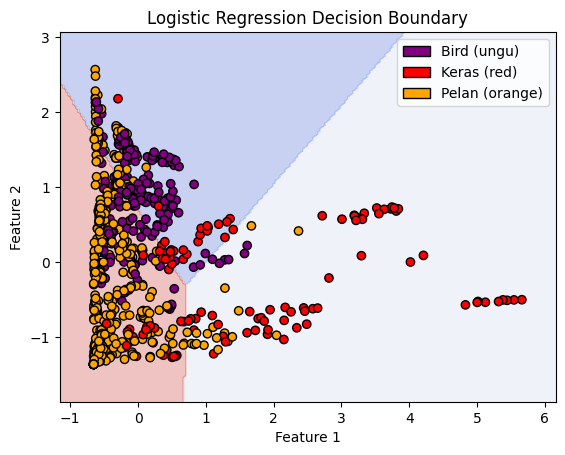

In [245]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Define custom colors
    color_map = {0: 'purple', 1: 'red', 2: 'orange'}
    colors = [color_map[label] for label in y]
    
    # Plot points with custom colors
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')

    # Custom legend
    legend_elements = [
        Patch(facecolor='purple', edgecolor='k', label='Bird (ungu)'),
        Patch(facecolor='red', edgecolor='k', label='Keras (red)'),
        Patch(facecolor='orange', edgecolor='k', label='Pelan (orange)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")
    plt.show()

X_scaled = scaler.transform(X)
plot_decision_boundary(model, X_scaled, y)

In [246]:
X = [(data[4], data[5]) for data in dataset_fe]
y_original = [data[3] for data in dataset_fe]
y = [1 if label == 0 or label == 1 else 0 for label in y_original]

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
display(confusion_matrix(y_test, y_pred))

Accuracy: 0.8265895953757225


array([[97, 10],
       [20, 46]], dtype=int64)

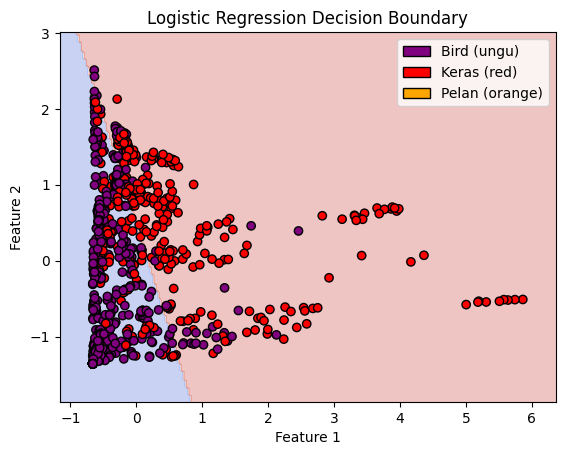

In [248]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Define custom colors
    color_map = {0: 'purple', 1: 'red', 2: 'orange'}
    colors = [color_map[label] for label in y]
    
    # Plot points with custom colors
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')

    # Custom legend
    legend_elements = [
        Patch(facecolor='purple', edgecolor='k', label='Bird (ungu)'),
        Patch(facecolor='red', edgecolor='k', label='Keras (red)'),
        Patch(facecolor='orange', edgecolor='k', label='Pelan (orange)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")
    plt.show()

X_scaled = scaler.transform(X)
plot_decision_boundary(model, X_scaled, y)

In [249]:
print("Coefficients (weights) per class:")
print(model.coef_)

print("\nIntercepts (bias) per class:")
print(model.intercept_)

Coefficients (weights) per class:
[[2.42586353 0.86888415]]

Intercepts (bias) per class:
[-0.40963092]


In [256]:
dataset_rmszcr

[('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  0.0,
  1.0,
  2,
  0.011059444,
  0.23255173703457446),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  0.5,
  1.0,
  2,
  0.023861289,
  0.23291015625),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  1.0,
  1.0,
  2,
  0.054715376,
  0.2427952543218085),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  1.5,
  1.0,
  0,
  0.08369124,
  0.24529379986702127),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  2.0,
  1.0,
  0,
  0.088784575,
  0.2437458444148936),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  2.5,
  1.0,
  0,
  0.0764381,
  0

In [257]:
dataset_fe

[('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  0.0,
  1.0,
  2,
  0.011059444,
  0.23255173703457446,
  array([[2.22129905e-13, 1.03116427e-09, 1.56951060e-07, ...,
          5.70585842e-13, 1.14141976e-07, 3.86931497e-05],
         [1.73044982e-13, 1.74463599e-09, 6.80466954e-08, ...,
          5.17760639e-13, 1.17636276e-07, 3.98712073e-05],
         [1.94202402e-13, 1.31313471e-09, 1.05966667e-08, ...,
          2.38242260e-12, 1.35159581e-07, 4.56374873e-05],
         ...,
         [2.20867216e-16, 3.81760608e-16, 5.07324878e-16, ...,
          5.14235058e-14, 2.11715911e-09, 6.91677428e-07],
         [9.88679711e-21, 1.61993748e-18, 5.16642328e-18, ...,
          3.58666228e-16, 2.08386641e-09, 6.80778953e-07],
         [4.95487801e-22, 1.56139436e-20, 6.90402098e-21, ...,
          3.08383758e-16, 2.06350248e-09, 6.74107753e-07]], dtype=float32)),
 ('C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artifici

# Save


In [258]:
with open(f"{MAIN_PATH}/Dataset/dataset_rmszcrlms.pkl", "wb") as f:
    pickle.dump(dataset_fe, f)

with open(f"{MAIN_PATH}/Dataset/dataset_rmszcr.pkl", "wb") as f:
    pickle.dump(dataset_rmszcr, f)